<a href="https://colab.research.google.com/github/isiri01/EN3160---Image-Processing-and-Machine-Vision/blob/main/Assignment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

Current sigma value: 1.0
Current sigma value: 1.5
Parameters of the largest circle:
Center: (92, 217)
Radius: 14
Sigma value: 1.5


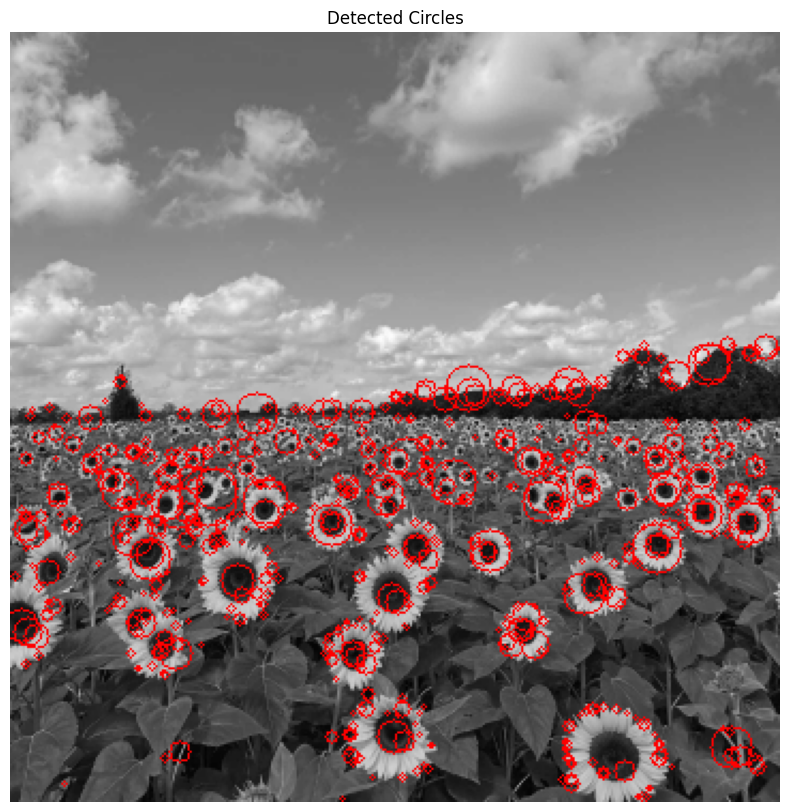

In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the sunflower field image
sunflower = cv.imread('/content/drive/MyDrive/A02/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
sunflower_grey = cv.cvtColor(sunflower, cv.COLOR_BGR2GRAY)

# Set up parameters for scale-space extrema detection
min_sigma = 1.0  # Minimum sigma value (smaller values for smaller blobs)
max_sigma = 1.5  # Maximum sigma value (larger values for larger blobs)
num_sigma = 2   # Number of sigma values to test
threshold = 0.3  # Threshold for blob detection

circles = []
# Loop through different sigma values to detect blobs at different scales
for sigma in np.linspace(min_sigma, max_sigma, num_sigma):

    # Print the current sigma value to the console
    print(f"Current sigma value: {sigma}")

    # Apply GaussianBlur (to simulate scale-space) to the grayscale image with the current sigma
    blurred = cv.GaussianBlur(sunflower_grey, (0, 0), sigma)

    # Apply the Laplacian (LoG approximation) to find blobs
    laplacian = cv.Laplacian(blurred, cv.CV_64F)

    # Calculate the absolute Laplacian values
    abs_laplacian = np.abs(laplacian)

    # Create a binary image where blobs are detected using the threshold
    blob_mask = abs_laplacian > threshold * abs_laplacian.max()

    # Find contours in the blob mask
    contours, _ = cv.findContours(blob_mask.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Loop through the detected contours and fit circles to them
    for contour in contours:
        if len(contour) >= 5:  # Fit enclosing circle only if enough points are in the contour
            (x, y), radius = cv.minEnclosingCircle(contour)
            center = (int(x), int(y))
            radius = int(radius)
            circles.append((center, radius, sigma))

# Sort the detected circles by radius in descending order
circles.sort(key=lambda x: -x[1])

# Report the parameters of the largest circle
if circles:
    largest_circle = circles[0]
    center, radius, sigma = largest_circle

    print("Parameters of the largest circle:")
    print(f"Center: {center}")
    print(f"Radius: {radius}")
    print(f"Sigma value: {sigma}")

# Set the desired line thickness for drawn circles
line_thickness = 1

# Draw all detected circles with the specified line thickness
output_image = cv.cvtColor(sunflower_grey, cv.COLOR_GRAY2BGR)
for circle in circles:
    center, radius, _ = circle
    cv.circle(output_image, center, radius, (0, 0, 255), line_thickness)  # Red color

# Display the grayscale image with detected circles using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')
plt.title('Detected Circles')
plt.show()





Number of inliers in the line: 26
Parameters of the estimated line:
a: 0.7076396074207529
b: 0.7065735532466069
d: 1.6032276266419858
Number of remnant points: 76
Number of inliers in the circle: 38
Parameters of the estimated circle:
x_center: 1.9448363472906443
y_center: 2.9560160908586575
radius: 10.099625959084278
Estimated line parameters: a=0.7076, b=0.7066, d=1.6032
Estimated circle parameters: x0=1.9448, y0=2.9560, r=10.0996


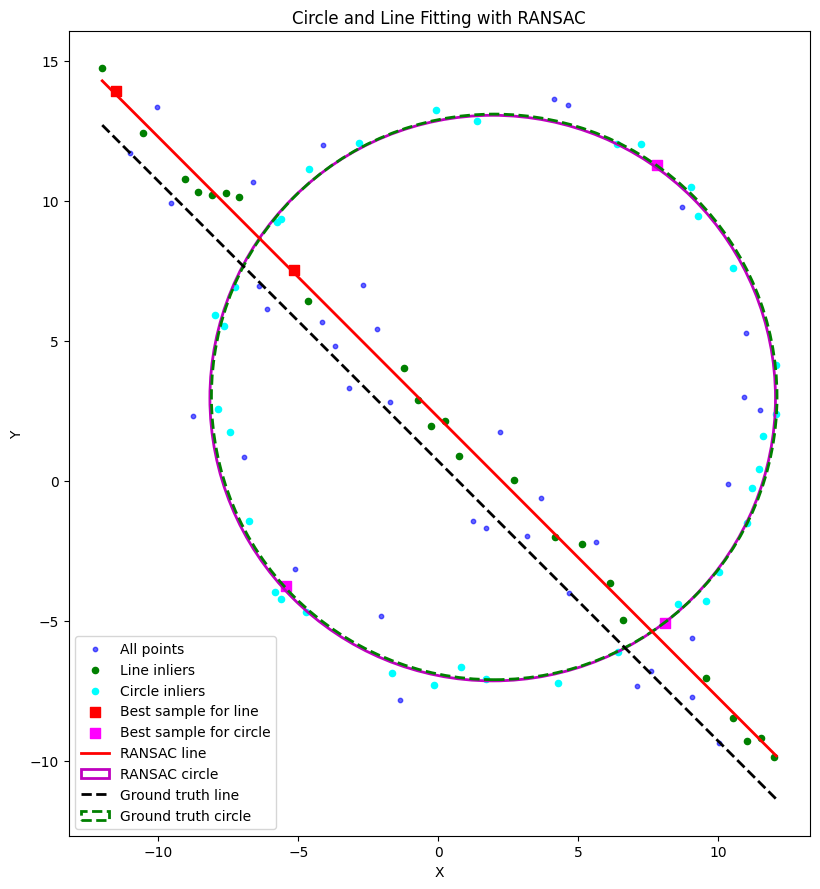

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.optimize import minimize

# Generate a noisy point set that conforms to a line and a circle
N = 100  # Total number of points
half_n = N // 2  # Half for circle, half for line

# Circle parameters
r = 10  # Radius
x0_gt, y0_gt = 2, 3  # Ground truth center of the circle
s = r / 16  # Standard deviation of noise on the radius
t = np.random.uniform(0, 2 * np.pi, half_n)  # Angle parameter for the circle
n = s * np.random.randn(half_n)  # Noise

# Generate circle points
x_circ = x0_gt + (r + n) * np.cos(t)
y_circ = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x_circ.reshape(half_n, 1), y_circ.reshape(half_n, 1)))

# Line parameters
s_line = 1.0  # Standard deviation of noise on the line
m, b = -1, 2  # Slope and intercept of the line

# Generate line points
x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s_line * np.random.randn(half_n)
X_line = np.hstack((x_line.reshape(half_n, 1), y_line.reshape(half_n, 1)))




def distance_point_to_line(points, a, b, d):
    return np.abs(a * points[:, 0] + b * points[:, 1] - d)

def fit_line(points):
    def objective(params):
        a, b, d = params
        return np.sum(distance_point_to_line(points, a, b, d)**2)

    def constraint(params):
        a, b, _ = params
        return a**2 + b**2 - 1

    initial_guess = [1, 1, 0]
    result = minimize(objective, initial_guess, method='SLSQP', constraints={'type': 'eq', 'fun': constraint})
    return result.x

def ransac_line(points, num_iterations, threshold, min_inliers):
    best_model = None
    best_inliers = np.array([])
    best_sample = None

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(points), 2, replace=False)
        sample_points = points[sample_indices]

        p1, p2 = sample_points
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        c = p1[0]*p2[1] - p2[0]*p1[1]
        norm = np.sqrt(a**2 + b**2)
        a, b = a/norm, b/norm
        d = c/norm

        distances = distance_point_to_line(points, a, b, d)
        inlier_mask = distances < threshold
        inliers = points[inlier_mask]

        if len(inliers) > min_inliers and len(inliers) > len(best_inliers):
            best_model = fit_line(inliers)
            best_inliers = inliers
            best_sample = sample_points

    return best_model, best_inliers, best_sample

def distance_point_to_circle(points, x0, y0, r):
    return np.abs(np.sqrt((points[:, 0] - x0)**2 + (points[:, 1] - y0)**2) - r)

def fit_circle(points):
    def objective(params):
        x0, y0, r = params
        return np.sum(distance_point_to_circle(points, x0, y0, r)**2)

    center_guess = np.mean(points, axis=0)
    radius_guess = np.mean(np.linalg.norm(points - center_guess, axis=1))
    initial_guess = [center_guess[0], center_guess[1], radius_guess]

    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x

def ransac_circle(points, num_iterations, threshold, min_inliers):
    best_model = None
    best_inliers = np.array([])
    best_sample = None

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(points), 3, replace=False)
        sample_points = points[sample_indices]

        x0, y0, r = fit_circle(sample_points)

        distances = distance_point_to_circle(points, x0, y0, r)
        inlier_mask = distances < threshold
        inliers = points[inlier_mask]

        if len(inliers) > min_inliers and len(inliers) > len(best_inliers):
            best_model = fit_circle(inliers)
            best_inliers = inliers
            best_sample = sample_points

    return best_model, best_inliers, best_sample


# Perform RANSAC for line estimation
num_iterations_line = 1000
line_threshold = 0.5
min_inliers_line = len(X) // 4

best_line, line_inliers, best_line_sample = ransac_line(X, num_iterations_line, line_threshold, min_inliers_line)

# Calculate distances to the line and select remaining points
a, b, d = best_line
distances_to_line = distance_point_to_line(X, a, b, d)
remaining_points = X[distances_to_line > line_threshold]

# Print line estimation details
print(f"Number of inliers in the line: {len(line_inliers)}")
print("Parameters of the estimated line:")
print(f"a: {a}")
print(f"b: {b}")
print(f"d: {d}")
print(f"Number of remnant points: {len(remaining_points)}")

# Perform RANSAC for circle estimation
num_iterations_circle = 1000
circle_threshold = 0.5
min_inliers_circle = len(remaining_points) // 3

best_circle, circle_inliers, best_circle_sample = ransac_circle(remaining_points, num_iterations_circle, circle_threshold, min_inliers_circle)

# Print circle estimation details
print(f"Number of inliers in the circle: {len(circle_inliers)}")
print("Parameters of the estimated circle:")
print(f"x_center: {best_circle[0]}")
print(f"y_center: {best_circle[1]}")
print(f"radius: {best_circle[2]}")

print(f"Estimated line parameters: a={best_line[0]:.4f}, b={best_line[1]:.4f}, d={best_line[2]:.4f}")
print(f"Estimated circle parameters: x0={best_circle[0]:.4f}, y0={best_circle[1]:.4f}, r={best_circle[2]:.4f}")

# Plotting
fig, ax = plt.subplots(figsize=(9, 9))

# Plot all points
ax.scatter(X[:, 0], X[:, 1], c='blue', s=10, alpha=0.6, label='All points')

# Plot line inliers
ax.scatter(line_inliers[:, 0], line_inliers[:, 1], c='green', s=20, label='Line inliers')

# Plot circle inliers
ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], c='cyan', s=20, label='Circle inliers')

# Plot best sample for line
ax.scatter(best_line_sample[:, 0], best_line_sample[:, 1], c='red', s=50, marker='s', label='Best sample for line')

# Plot best sample for circle
ax.scatter(best_circle_sample[:, 0], best_circle_sample[:, 1], c='magenta', s=50, marker='s', label='Best sample for circle')

# Plot best-fit line
x_range = np.array([X[:, 0].min(), X[:, 0].max()])
y_range = (-a * x_range + d) / b
ax.plot(x_range, y_range, 'r-', linewidth=2, label='RANSAC line')

# Plot best-fit circle
x0, y0, r = best_circle
circle = plt.Circle((x0, y0), r, color='m', fill=False, linewidth=2, label='RANSAC circle')
ax.add_artist(circle)

# Plot ground truth shapes (assuming we have them)
# Ground truth line
x_vals = np.array([X[:, 0].min(), X[:, 0].max()])
y_vals = m * x_vals + b
ax.plot(x_vals, y_vals, 'k--', linewidth=2, label='Ground truth line')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, linestyle='--', linewidth=2, label='Ground truth circle')
ax.add_artist(circle_gt)

ax.set_aspect('equal')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Circle and Line Fitting with RANSAC')

plt.tight_layout()
plt.show()




Number of inliers in the circle: 37
Parameters of the estimated circle:
x_center: 1.9514
y_center: 2.8842
radius: 10.0573
Number of remnant points: 65
Number of inliers in the line: 25
Parameters of the estimated line:
a: 0.7082
b: 0.7060
d: 1.6210


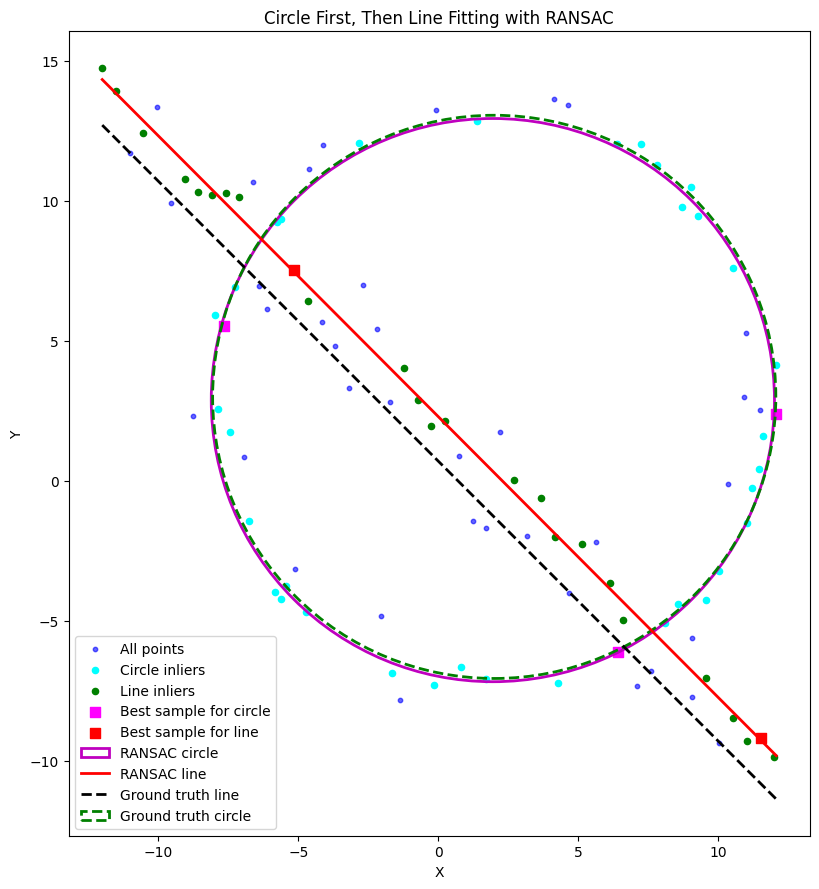

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.optimize import minimize

# Generate a noisy point set that conforms to a line and a circle
N = 100  # Total number of points
half_n = N // 2  # Half for circle, half for line

# Circle parameters
r = 10  # Radius
x0_gt, y0_gt = 2, 3  # Ground truth center of the circle
s = r / 16  # Standard deviation of noise on the radius
t = np.random.uniform(0, 2 * np.pi, half_n)  # Angle parameter for the circle
n = s * np.random.randn(half_n)  # Noise

# Generate circle points
x_circ = x0_gt + (r + n) * np.cos(t)
y_circ = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x_circ.reshape(half_n, 1), y_circ.reshape(half_n, 1)))

# Line parameters
s_line = 1.0  # Standard deviation of noise on the line
m, b = -1, 2  # Slope and intercept of the line

# Generate line points
x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s_line * np.random.randn(half_n)
X_line = np.hstack((x_line.reshape(half_n, 1), y_line.reshape(half_n, 1)))




def distance_point_to_line(points, a, b, d):
    return np.abs(a * points[:, 0] + b * points[:, 1] - d)

def fit_line(points):
    def objective(params):
        a, b, d = params
        return np.sum(distance_point_to_line(points, a, b, d)**2)

    def constraint(params):
        a, b, _ = params
        return a**2 + b**2 - 1

    initial_guess = [1, 1, 0]
    result = minimize(objective, initial_guess, method='SLSQP', constraints={'type': 'eq', 'fun': constraint})
    return result.x

def ransac_line(points, num_iterations, threshold, min_inliers):
    best_model = None
    best_inliers = np.array([])
    best_sample = None

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(points), 2, replace=False)
        sample_points = points[sample_indices]

        p1, p2 = sample_points
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        c = p1[0]*p2[1] - p2[0]*p1[1]
        norm = np.sqrt(a**2 + b**2)
        a, b = a/norm, b/norm
        d = c/norm

        distances = distance_point_to_line(points, a, b, d)
        inlier_mask = distances < threshold
        inliers = points[inlier_mask]

        if len(inliers) > min_inliers and len(inliers) > len(best_inliers):
            best_model = fit_line(inliers)
            best_inliers = inliers
            best_sample = sample_points

    return best_model, best_inliers, best_sample

def distance_point_to_circle(points, x0, y0, r):
    return np.abs(np.sqrt((points[:, 0] - x0)**2 + (points[:, 1] - y0)**2) - r)

def fit_circle(points):
    def objective(params):
        x0, y0, r = params
        return np.sum(distance_point_to_circle(points, x0, y0, r)**2)

    center_guess = np.mean(points, axis=0)
    radius_guess = np.mean(np.linalg.norm(points - center_guess, axis=1))
    initial_guess = [center_guess[0], center_guess[1], radius_guess]

    result = minimize(objective, initial_guess, method='Nelder-Mead')
    return result.x

def ransac_circle(points, num_iterations, threshold, min_inliers):
    best_model = None
    best_inliers = np.array([])
    best_sample = None

    for _ in range(num_iterations):
        sample_indices = np.random.choice(len(points), 3, replace=False)
        sample_points = points[sample_indices]

        x0, y0, r = fit_circle(sample_points)

        distances = distance_point_to_circle(points, x0, y0, r)
        inlier_mask = distances < threshold
        inliers = points[inlier_mask]

        if len(inliers) > min_inliers and len(inliers) > len(best_inliers):
            best_model = fit_circle(inliers)
            best_inliers = inliers
            best_sample = sample_points

    return best_model, best_inliers, best_sample
# Perform RANSAC for circle estimation first
num_iterations_circle = 1000
circle_threshold = 0.5
min_inliers_circle = len(X) // 3

best_circle, circle_inliers, best_circle_sample = ransac_circle(X, num_iterations_circle, circle_threshold, min_inliers_circle)

# Print circle estimation details
print(f"Number of inliers in the circle: {len(circle_inliers)}")
print("Parameters of the estimated circle:")
print(f"x_center: {best_circle[0]:.4f}")
print(f"y_center: {best_circle[1]:.4f}")
print(f"radius: {best_circle[2]:.4f}")

# Calculate distances to the circle and select remaining points
x0, y0, r = best_circle
distances_to_circle = distance_point_to_circle(X, x0, y0, r)
remaining_points = X[distances_to_circle > circle_threshold]
print(f"Number of remnant points: {len(remaining_points)}")

# Perform RANSAC for line estimation on remaining points
num_iterations_line = 1000
line_threshold = 0.5
min_inliers_line = len(remaining_points) // 4

best_line, line_inliers, best_line_sample = ransac_line(remaining_points, num_iterations_line, line_threshold, min_inliers_line)

# Print line estimation details
print(f"Number of inliers in the line: {len(line_inliers)}")
print("Parameters of the estimated line:")
print(f"a: {best_line[0]:.4f}")
print(f"b: {best_line[1]:.4f}")
print(f"d: {best_line[2]:.4f}")

# Plotting
fig, ax = plt.subplots(figsize=(9, 9))

# Plot all points
ax.scatter(X[:, 0], X[:, 1], c='blue', s=10, alpha=0.6, label='All points')

# Plot circle inliers
ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], c='cyan', s=20, label='Circle inliers')

# Plot line inliers
ax.scatter(line_inliers[:, 0], line_inliers[:, 1], c='green', s=20, label='Line inliers')

# Plot best sample for circle
ax.scatter(best_circle_sample[:, 0], best_circle_sample[:, 1], c='magenta', s=50, marker='s', label='Best sample for circle')

# Plot best sample for line
ax.scatter(best_line_sample[:, 0], best_line_sample[:, 1], c='red', s=50, marker='s', label='Best sample for line')

# Plot best-fit circle
circle = plt.Circle((x0, y0), r, color='m', fill=False, linewidth=2, label='RANSAC circle')
ax.add_artist(circle)

# Plot best-fit line
a, b, d = best_line
x_range = np.array([X[:, 0].min(), X[:, 0].max()])
y_range = (-a * x_range + d) / b
ax.plot(x_range, y_range, 'r-', linewidth=2, label='RANSAC line')

# Plot ground truth shapes (assuming we have them)
x_vals = np.array([X[:, 0].min(), X[:, 0].max()])
y_vals = m * x_vals + b
ax.plot(x_vals, y_vals, 'k--', linewidth=2, label='Ground truth line')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, linestyle='--', linewidth=2, label='Ground truth circle')
ax.add_artist(circle_gt)

ax.set_aspect('equal')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Circle First, Then Line Fitting with RANSAC')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
building_image = cv2.imread('005.jpg')
flag_image = cv2.imread('flag.png')

# Step 1: Select points on the building image
def on_click(event, points):
    if event.button == 1 and len(points) < 4:
        points.append((event.xdata, event.ydata))
        plt.plot(event.xdata, event.ydata, 'ro')
        plt.draw()

points = []
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(building_image, cv2.COLOR_BGR2RGB))
fig.canvas.mpl_connect('button_press_event', lambda event: on_click(event, points))
plt.title("Select 4 points on the image")
plt.show()

dst_points = np.array(points, dtype=np.float32)

# Step 2: Define source points (corners of the flag image)
h, w = flag_image.shape[:2]
src_points = np.array([(0, 0), (w, 0), (w, h), (0, h)], dtype=np.float32)

# Step 3: Compute homography
H, _ = cv2.findHomography(src_points, dst_points)

# Step 4: Warp the flag image using the computed homography
warped_flag = cv2.warpPerspective(flag_image, H, (building_image.shape[1], building_image.shape[0]))

# Step 5: Create a mask for the warped flag
gray_warped = cv2.cvtColor(warped_flag, cv2.COLOR_BGR2GRAY)
_, mask = cv2.threshold(gray_warped, 1, 255, cv2.THRESH_BINARY)

# Step 6: Blend the warped flag with the building image
blended = building_image.copy()
blended[mask != 0] = warped_flag[mask != 0]

# Step 7: Display the original and the blended image
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(cv2.cvtColor(building_image, cv2.COLOR_BGR2RGB)), plt.title('Original Image')
plt.subplot(122), plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB)), plt.title('Image with Superimposed Flag')
plt.show()

# Step 8: Save the blended result
cv2.imwrite('result_wadham_college_with_flag.jpg', blended)
print("Result saved as 'result_wadham_college_with_flag.jpg'")
